In [0]:
import numpy as np 
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import random
import sys
%matplotlib inline 
from pyspark.sql import functions as fn

# import pydotplus
from IPython.display import Image

## Banco de Dados - Banknote Authentication

- O conjunto de dados foi obtido a partir de imagens notas bancárias autênticas e falsas. As imagens foram capturadas de amostras fornecidas por uma instituição bancária.
- Atributos: O conjunto de dados possui quatro atributos numéricos extraídos das imagens das notas. Esses atributos são:
- Variância da imagem transformada em wavelet (variance).
- Assimetria da imagem transformada em wavelet (skewness).
- Curtose da imagem transformada em wavelet (curtosis).
- Entropia da imagem (entropy).
- **Classe alvo: A classe alvo indica se uma nota bancária é autêntica (classe 0) ou falsa (classe 1).**

## Tratamento dos Dados

- Transforme o dataframe de pandas para PySpark
- transforme o nome das colunas para caixa alta
- **OBS:** não esqueça de verificar se as colunas numéricas estão como tipo 'double'

## Análise Exploratória

- Existe alguma correlação entre as características? **Dica: faça o gráfico pairplot visto em aulas passadas**
- Como as características se distribuem em relação às classes? **Dica: faça histogramas visto em aulas passadas separando por classe para verificar esse ponto**
- Existem outliers presentes nas características?
- Como a distribuição das classes (autênticas e falsas) está equilibrada nos dados, isto é, **os dados estão balanceados?**

## Modelagem

- Faça o balanceamento das classes, caso não estejam 
- Aplique o modelo SVM (LinearSVC) igual fizemos com a árvore de decisão: **separar o que é variável X de Y, os dados de treino dos dados de teste, fitar o modelo, etc**
- Faça a matriz de confusão
- Calcule as métricas de avaliação
- Os valores obtidos foram satisfatórios?

# Dados

In [0]:
# URL do conjunto de dados
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

# Colunas do DataFrame
columns = ["variance", "skewness", "curtosis", "entropy", "class"]

# Carregar o conjunto de dados em um DataFrame do pandas
df = pd.read_csv(url, names=columns)

df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [0]:
spark_df = spark.createDataFrame(df)

In [0]:
#converter categorias para CAPS. 
df_spark_corrigido = (
    spark_df
    .select(
        'VARIANCE',
        'SKEWNESS',
        'CURTOSIS',
        'ENTROPY',
        'CLASS'
    )
)

display(df_spark_corrigido)


VARIANCE,SKEWNESS,CURTOSIS,ENTROPY,CLASS
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [0]:
#transformar variaveis para double. 

df_spark_corrigido = (
    df_spark_corrigido
    .select(
        # fn, auxilia qdo precisa realizar algum tratamento de colunas em SPARK
        fn.col('VARIANCE').cast('double'), # transformar para valores numericos
        fn.col('SKEWNESS').cast('double'), # transformar para valores numericos
        fn.col('CURTOSIS').cast('double'), # transformar para valores numericos
        fn.col('ENTROPY').cast('double'), # transformar para valores numericos
        fn.col('CLASS').cast('double'), # transformar para valores numericos
    )
)

In [0]:
#converter spark para pandas. 

df_data = df_spark_corrigido.toPandas()
df_data.head()

,VARIANCE,SKEWNESS,CURTOSIS,ENTROPY,CLASS
0,3.62160,8.6661,-2.8073,-0.44699,0.0
1,4.54590,8.1674,-2.4586,-1.46210,0.0
2,3.86600,-2.6383,1.9242,0.10645,0.0
3,3.45660,9.5228,-4.0112,-3.59440,0.0
4,0.32924,-4.4552,4.5718,-0.98880,0.0


In [0]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VARIANCE  1372 non-null   float64
 1   SKEWNESS  1372 non-null   float64
 2   CURTOSIS  1372 non-null   float64
 3   ENTROPY   1372 non-null   float64
 4   CLASS     1372 non-null   float64
dtypes: float64(5)
memory usage: 53.7 KB


### Analise Exploratória
* Fazer uma breve análise exploratória dos dados, entendendo as variáveis que estão sendo trabalhadas (plotar histograma, etc)

In [0]:
df = px.data.tips()

fig = px.histogram(df_data, x="VARIANCE", color="CLASS", marginal="box", opacity=0.5)

fig.update_layout(title_text='Distribuição - Tamanho das VARIANCE')

fig.show()

In [0]:
display(df_data)

VARIANCE,SKEWNESS,CURTOSIS,ENTROPY,CLASS
3.6216,8.6661,-2.8073,-0.44699,0.0
4.5459,8.1674,-2.4586,-1.4621,0.0
3.866,-2.6383,1.9242,0.10645,0.0
3.4566,9.5228,-4.0112,-3.5944,0.0
0.32924,-4.4552,4.5718,-0.9888,0.0
4.3684,9.6718,-3.9606,-3.1625,0.0
3.5912,3.0129,0.72888,0.56421,0.0
2.0922,-6.81,8.4636,-0.60216,0.0
3.2032,5.7588,-0.75345,-0.61251,0.0
1.5356,9.1772,-2.2718,-0.73535,0.0


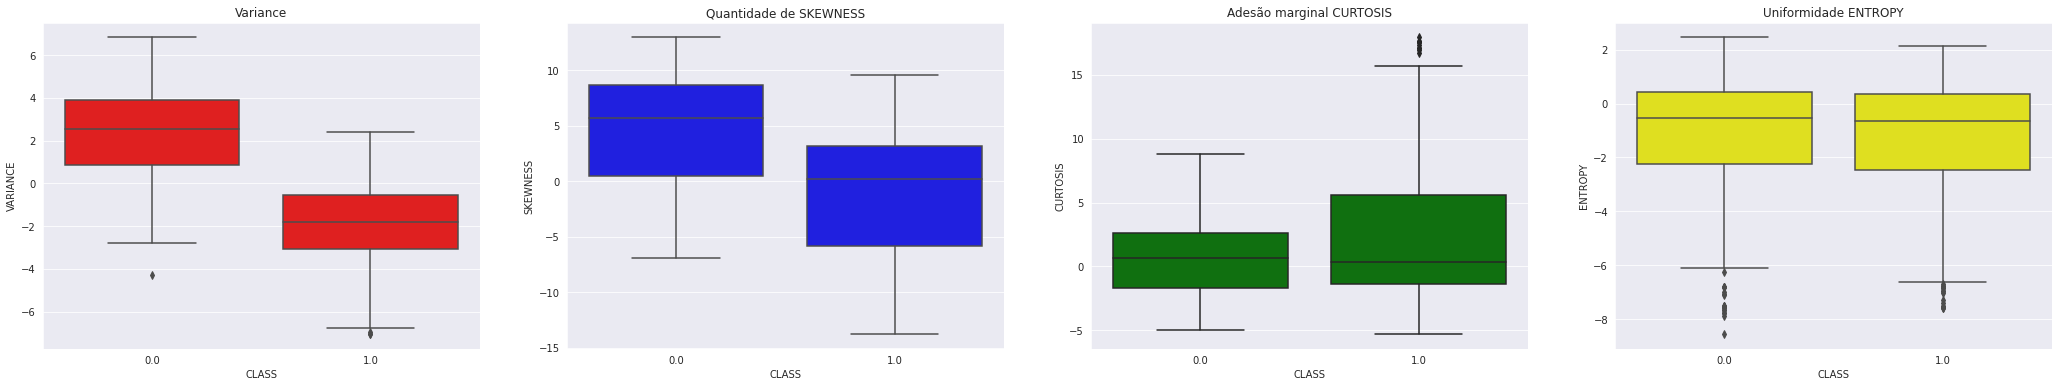

In [0]:
variaveis = ['VARIANCE', 'SKEWNESS', 'CURTOSIS', 'ENTROPY']
color = ['red', 'blue', 'green', 'yellow', 'orange']
descricao_variavel = ['Variance', 'Quantidade de SKEWNESS','Adesão marginal CURTOSIS', 'Uniformidade ENTROPY']

# cria um loop para criar um gráfico boxplot para cada variável
fig, axs = plt.subplots(ncols=len(variaveis), figsize=(36, 6))
for i, variavel in enumerate(variaveis):
    sns.boxplot(x='CLASS', y=variavel, data=df_data, ax=axs[i], color=color[i])
    axs[i].set_title(descricao_variavel[i])

# exibe o gráfico
plt.show()

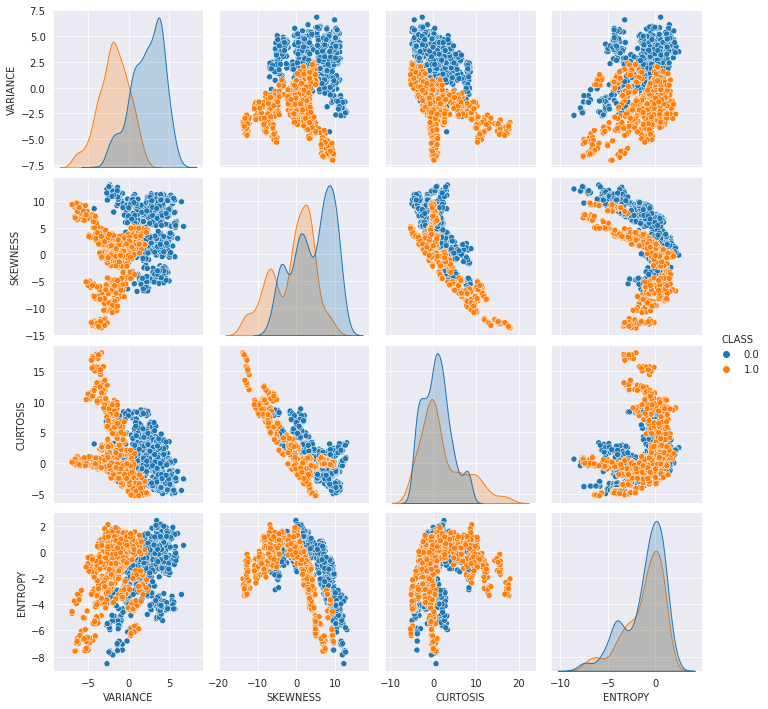

In [0]:
sns.set_style('darkgrid')

sns.pairplot(df_data, hue='CLASS')

plt.show()

Out[39]: <AxesSubplot:>

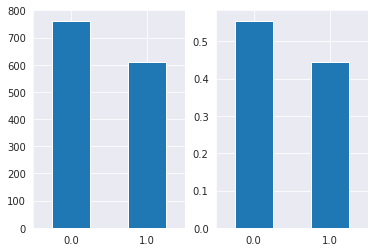

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2)

df_data.CLASS.value_counts().plot(kind='bar', rot=0, ax=axs[0])
df_data.CLASS.value_counts(normalize=True).plot(kind='bar', rot=0, ax=axs[1])

### ARVORE DE DECISAO
* Testar um modelo de árvore de decisão

In [0]:
# BALANCEANDO DADOS
df_falso = df_data[df_data['CLASS'] == 1]
df_autentico = df_data[df_data['CLASS'] == 0]

In [0]:
df_balanceado = pd.concat([
    df_falso,
    df_autentico.sample(n=len(df_falso))], axis=0
)

Out[44]: <AxesSubplot:>

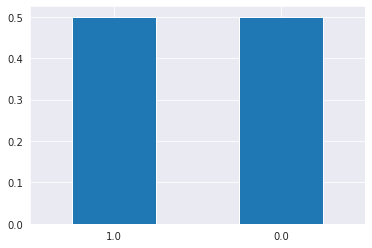

In [0]:
df_balanceado.CLASS.value_counts(normalize=True).plot(kind='bar', rot=0)

In [0]:
display(df_balanceado)

VARIANCE,SKEWNESS,CURTOSIS,ENTROPY,CLASS
-1.3971,3.3191,-1.3927,-1.9948,1.0
0.39012,-0.14279,-0.031994,0.35084,1.0
-1.6677,-7.1535,7.8929,0.96765,1.0
-3.8483,-12.8047,15.6824,-1.281,1.0
-3.5681,-8.213,10.083,0.96765,1.0
-2.2804,-0.30626,1.3347,1.3763,1.0
-1.7582,2.7397,-2.5323,-2.234,1.0
-0.89409,3.1991,-1.8219,-2.9452,1.0
0.3434,0.12415,-0.28733,0.14654,1.0
-0.9854,-6.661,5.8245,0.5461,1.0


In [0]:
Y = df_balanceado['CLASS'].values # transformamos em valores para virar um vetor (matriz) - requisicao da decision tree

X = df_balanceado[['VARIANCE','SKEWNESS','CURTOSIS','ENTROPY']].values

In [0]:
# DIVIDINDO BASE TREINO E TESTE
np.random.seed(1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [0]:
dtree = DecisionTreeClassifier(
    splitter = 'best',
    criterion = 'entropy',
    max_depth = None,
    random_state = 0
)

SVM = LinearSVC()

In [0]:
#treinando o modelo
modelo = dtree.fit(X_train, Y_train)

In [0]:
Y_predict = modelo.predict(X_test)

In [0]:
display(df_balanceado)

VARIANCE,SKEWNESS,CURTOSIS,ENTROPY,CLASS
-1.3971,3.3191,-1.3927,-1.9948,1.0
0.39012,-0.14279,-0.031994,0.35084,1.0
-1.6677,-7.1535,7.8929,0.96765,1.0
-3.8483,-12.8047,15.6824,-1.281,1.0
-3.5681,-8.213,10.083,0.96765,1.0
-2.2804,-0.30626,1.3347,1.3763,1.0
-1.7582,2.7397,-2.5323,-2.234,1.0
-0.89409,3.1991,-1.8219,-2.9452,1.0
0.3434,0.12415,-0.28733,0.14654,1.0
-0.9854,-6.661,5.8245,0.5461,1.0


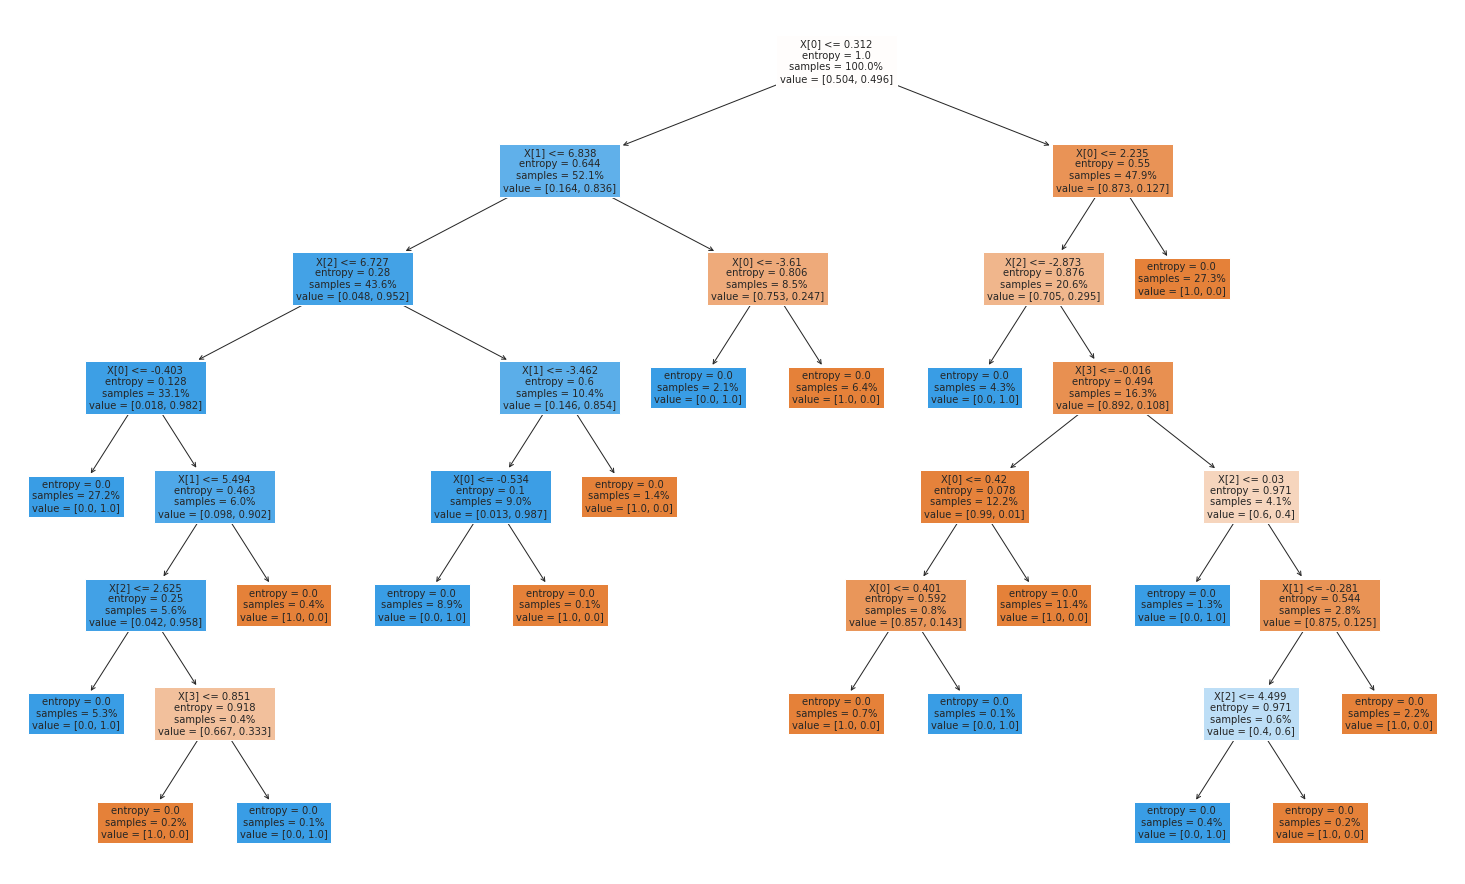

In [0]:
#criando arvore de decisão
features_names = ['VARIANCE','SKEWNESS','CURTOSIS','ENTROPY']
nome_classes = modelo.classes_

fig = plt.figure(figsize=(26, 16))
plot_tree(modelo, proportion=True, fontsize=10, impurity=True,
          filled=True   
         )

plt.show()

<command-1530745494605411>:11: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



Matriz de Confusão sem normalizacão 
[[175   5]
 [  2 184]]


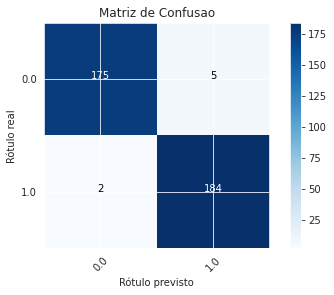

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão sem normalizacão ')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo real')
    plt.xlabel('Rótulo previsto')

matrix_confusao = confusion_matrix(Y_test, Y_predict)

plt.figure()

plot_confusion_matrix(matrix_confusao, classes=nome_classes,
                      title='Matriz de Confusao')

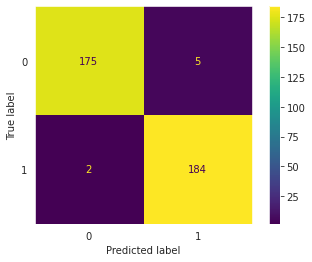

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_predict), display_labels=['0', '1']).plot()
plt.grid(False)
plt.show()

In [0]:
recall_score(Y_test, Y_predict)

Out[82]: 0.989247311827957

In [0]:
f1_score(Y_test, Y_predict)

Out[83]: 0.9813333333333333

In [0]:
accuracy_score(Y_test, Y_predict)

Out[84]: 0.9808743169398907

In [0]:
precision_score(Y_test, Y_predict)

Out[97]: 0.9735449735449735

In [0]:
print("recall_score -->", recall_score(Y_test, Y_predict))
print("f1_score -->", f1_score(Y_test, Y_predict))
print("accuracy_score -->", accuracy_score(Y_test, Y_predict))
print("precision_score -->", precision_score(Y_test, Y_predict))

recall_score --> 0.989247311827957
f1_score --> 0.9813333333333333
accuracy_score --> 0.9808743169398907
precision_score --> 0.9735449735449735


In [0]:
def plotar_comparacao_treino_validacao(X, y, valores_C):
    X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    precisoes_treino = []
    precisoes_val = []
    for C in valores_C:
        svm = LinearSVC(C=C, loss="hinge", max_iter=100000, random_state=42)
        svm.fit(X_treino, y_treino)
        y_pred_treino = svm.predict(X_treino)
        precisao_treino = accuracy_score(y_treino, y_pred_treino)
        precisoes_treino.append(precisao_treino)
        y_pred_val = svm.predict(X_val)
        precisao_val = accuracy_score(y_val, y_pred_val)
        precisoes_val.append(precisao_val)
    plt.figure(figsize=(20, 10))
    plt.plot(valores_C, precisoes_treino, label='Treino')
    plt.plot(valores_C, precisoes_val, label='Validação')
    plt.plot([1, 1], [0.98547, 0.98997], color='red', label='Valor Original de C')
    plt.xlabel('Valor de C')
    plt.ylabel('Precisão')
    plt.title('Busca de C')
    plt.legend()
    plt.show()

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/databricks/python/lib/python3.9/s

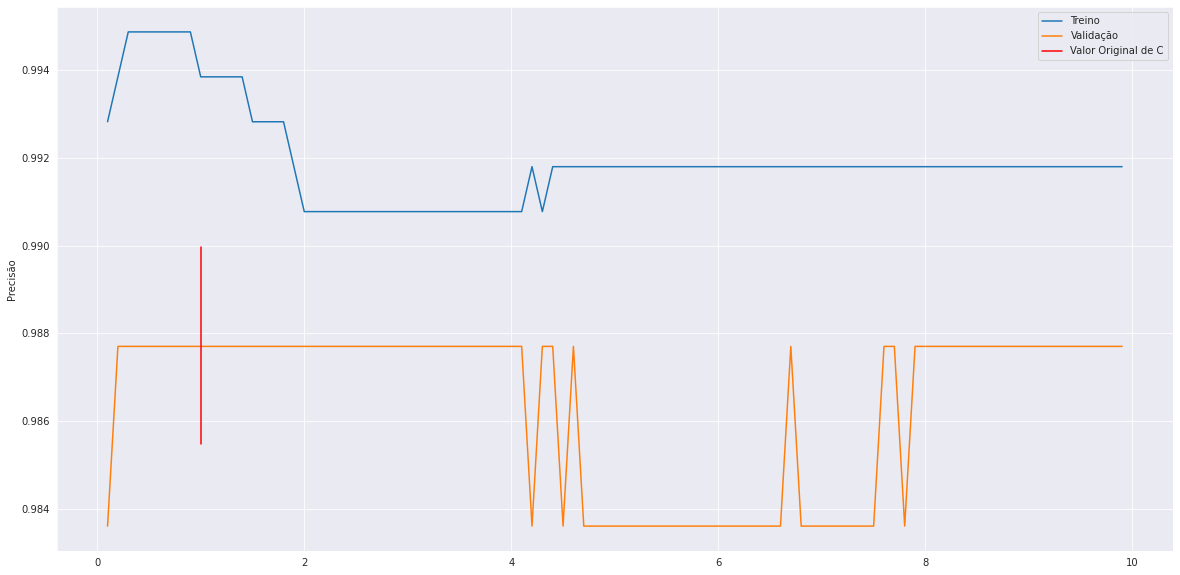

In [0]:
plotar_comparacao_treino_validacao(df_balanceado.drop(columns=['CLASS']), df_balanceado['CLASS'], np.arange(0.1, 10, 0.1))
